# 📊 Stripe Data Science Internship – Written Project
## ✨ Objective
The goal of this project is to develop a **quantitative approach** to identify existing Stripe merchants who are **high-potential targets** for a **sales or marketing campaign** to adopt the **Subscriptions** product.

## 📁 Datasets
1. **Payments Dataset**: Contains merchant-day transaction volumes for:
   - Subscriptions
   - Checkout
   - Payment Links

2. **Merchants Dataset**: Contains merchant metadata such as:
   - Signup date
   - Region
   - Company size
   - Industry

> All volume data is in **cents** and may include overlapping usage across products.

## 🧠 Approach
- **Data Cleaning & Merging**: Joined payments and merchant data to form a unified dataset.
- **Feature Engineering**: Derived useful metrics such as average volume per product and usage ratios.
- **Filtering Criteria**: Selected merchants who:
  - Are **not currently using Subscriptions**
  - Show **high engagement with Checkout or Payment Links**
  - Have sufficient account history (e.g., >90 days since signup)
  - Are **medium or large-sized businesses**
- **Scoring**: Ranked merchants based on volume, potential, and engagement levels.

## 📈 Outcome
Generated a ranked list of merchants to target for a Subscriptions adoption campaign. Also proposed an evaluation plan and next steps for the sales/marketing team.




## 01 Importing Neccessary Libraries

In [7]:
#  Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## 02 Load Data and Data Preprocessing


In [8]:
# loading the datasets
merchants_df = pd.read_csv("dstakehome_merchants.csv")
payments_df = pd.read_excel("dstakehome_payments.xlsx")


In [42]:
merchants_df.head()

,merchant,industry,first_charge_date,country,business_size
0,5d03e714,Education,2032-02-13 00:00:00+00:00,US,medium
1,da22f154,Others,2031-10-16 00:00:00+00:00,US,small
2,687eebc8,Software,2032-07-23 00:00:00+00:00,US,small
3,de478470,Software,2033-03-15 00:00:00+00:00,US,small
4,1e719b8a,Business services,2035-02-12 00:00:00+00:00,IT,small


In [43]:
payments_df.head()

,date,merchant,subscription_volume,checkout_volume,payment_link_volume,total_volume
0,2041-05-01T00:00:00Z,5d03e714,0.00,0.0000,0.0,425340
1,2041-05-01T00:00:00Z,da22f154,0.00,0.0000,0.0,17326
2,2041-05-01T00:00:00Z,687eebc8,7.94,0.0000,0.0,79400
3,2041-05-01T00:00:00Z,de478470,26.84,0.0000,0.0,268400
4,2041-05-01T00:00:00Z,1e719b8a,0.00,1.9895,0.0,19895


## 3 Data preperation

In [44]:
# Convert first_charge_date to datetime
# Safely convert to datetime; invalid ones will become NaT
merchants_df['first_charge_date'] = pd.to_datetime(merchants_df['first_charge_date'], errors='coerce')

# Convert volume from cents to dollars
#payments_df[['subscriptions_volume', 'checkout_volume', 'payment_link_volume']] /= 100

# Merge both datasets on 'merchant'
#df = payments_df.merge(merchants_df, on="merchant", how="left")


In [45]:
print(payments_df.columns.tolist())


['date', 'merchant', 'subscription_volume', 'checkout_volume', 'payment_link_volume', 'total_volume']


In [46]:
# Convert transaction volumes from cents to dollars
#    This improves readability and aligns with typical financial reporting
payments_df[['subscription_volume', 'checkout_volume', 'payment_link_volume']] /= 100


In [47]:
#  Merge merchant info with payment transactions using the 'merchant' ID
#    This creates a unified dataset for downstream analysis
df = payments_df.merge(merchants_df, on="merchant", how="left")

In [59]:
df.head(7)

,date,merchant,subscription_volume,checkout_volume,payment_link_volume,total_volume,industry,first_charge_date,country,business_size
0,2041-05-01T00:00:00Z,5d03e714,0.0000,0.000000,0.0,425340,Education,2032-02-13 00:00:00+00:00,US,medium
1,2041-05-01T00:00:00Z,da22f154,0.0000,0.000000,0.0,17326,Others,2031-10-16 00:00:00+00:00,US,small
2,2041-05-01T00:00:00Z,687eebc8,0.0794,0.000000,0.0,79400,Software,2032-07-23 00:00:00+00:00,US,small
3,2041-05-01T00:00:00Z,de478470,0.2684,0.000000,0.0,268400,Software,2033-03-15 00:00:00+00:00,US,small
4,2041-05-01T00:00:00Z,1e719b8a,0.0000,0.019895,0.0,19895,Business services,2035-02-12 00:00:00+00:00,IT,small
5,2041-05-01T00:00:00Z,15f61630,0.0000,0.000000,0.0,328500,Software,2032-05-27 00:00:00+00:00,US,small
6,2041-05-01T00:00:00Z,cede5ccf,0.0425,0.000000,0.0,42500,Software,2032-03-27 00:00:00+00:00,US,small


## 4: Identify Merchants Not Using Subscriptions

In [48]:
df.dtypes


date                                object
merchant                            object
subscription_volume                float64
checkout_volume                    float64
payment_link_volume                float64
total_volume                         int64
industry                            object
first_charge_date      datetime64[ns, UTC]
country                             object
business_size                       object
dtype: object

In [49]:
# Just to be sure — drop rows with missing merchant or volume
df = df.dropna(subset=["merchant", "subscription_volume"])

df["merchant"].apply(type).value_counts()

# Convert merchant column to string type
df["merchant"] = df["merchant"].astype(str)


# Group by merchant and sum subscription volume
merchant_sub_vol = df.groupby("merchant")["subscription_volume"].sum().reset_index()
merchant_sub_vol.columns = ["merchant", "total_subs_volume"]


# 3. Merge total subscription volume into the merchants table
merchant_summary = merchants_df.merge(merchant_sub_vol, on="merchant", how="left")

# 4. Fill NaN values with 0 — these are merchants who have never used Subscriptions

merchant_summary["total_subs_volume"] = merchant_summary["total_subs_volume"].fillna(0)


In [61]:
merchant_summary.head(8)

,merchant,industry,first_charge_date,country,business_size,total_subs_volume,checkout_volume,payment_link_volume,engagement_score
0,5d03e714,Education,2032-02-13 00:00:00+00:00,US,medium,0.000000,0.0000,0.00,0.0000
1,da22f154,Others,2031-10-16 00:00:00+00:00,US,small,0.000000,0.0000,0.77,0.7700
2,687eebc8,Software,2032-07-23 00:00:00+00:00,US,small,23.443156,0.0000,0.00,0.0000
3,de478470,Software,2033-03-15 00:00:00+00:00,US,small,45.038624,0.0000,0.00,0.0000
4,1e719b8a,Business services,2035-02-12 00:00:00+00:00,IT,small,0.000000,6916.2449,0.00,6916.2449
5,15f61630,Software,2032-05-27 00:00:00+00:00,US,small,0.000000,0.0000,0.00,0.0000
6,cede5ccf,Software,2032-03-27 00:00:00+00:00,US,small,0.595000,0.0000,0.00,0.0000
7,11f1600c,Software,2039-02-28 00:00:00+00:00,US,small,0.000000,0.0000,0.00,0.0000


## 5: Add Engagement from Other Products

In [50]:
print(other_vols.columns)


Index(['merchant', 'checkout_volume', 'payment_link_volume'], dtype='object')


In [51]:
# 1 Ensure 'merchant' column is of string type in both dataframes
merchant_summary["merchant"] = merchant_summary["merchant"].astype(str)
other_vols["merchant"] = other_vols["merchant"].astype(str)

# 2 Merge checkout & payment link volume data into merchant_summary
merchant_summary = merchant_summary.merge(other_vols, on="merchant", how="left")


In [53]:
print("merchant_summary columns:", merchant_summary.columns.tolist())


merchant_summary columns: ['merchant', 'industry', 'first_charge_date', 'country', 'business_size', 'total_subs_volume', 'checkout_volume', 'payment_link_volume']


In [55]:
# 3 Fill any missing values in the volume columns (just in case)
merchant_summary["checkout_volume"] = merchant_summary["checkout_volume"].fillna(0)
merchant_summary["payment_link_volume"] = merchant_summary["payment_link_volume"].fillna(0)

# 4 Create an engagement score based on other products
merchant_summary["engagement_score"] = (
    merchant_summary["checkout_volume"] + merchant_summary["payment_link_volume"]
)

# 5 Filter for merchants who have NOT used subscriptions but ARE active on other products
target_df = merchant_summary[
    (merchant_summary["total_subs_volume"] == 0) &
    (merchant_summary["engagement_score"] > 0)
].copy()


In [64]:
target_df.head(6)

,merchant,industry,first_charge_date,country,business_size,total_subs_volume,checkout_volume,payment_link_volume,engagement_score,days_since_signup
1,da22f154,Others,2031-10-16 00:00:00+00:00,US,small,0.0,0.0000,0.77,0.7700,3730.0
4,1e719b8a,Business services,2035-02-12 00:00:00+00:00,IT,small,0.0,6916.2449,0.00,6916.2449,2515.0
38,3361dde8,Software,2034-01-31 00:00:00+00:00,DE,small,0.0,26.3185,0.00,26.3185,2892.0
57,7296df3c,Others,2034-02-02 00:00:00+00:00,GB,small,0.0,413.1662,0.00,413.1662,2890.0
68,8c73a284,Business services,2041-01-26 00:00:00+00:00,CY,small,0.0,195.4550,0.00,195.4550,340.0
80,9879a7d6,Leisure,2035-01-02 00:00:00+00:00,US,small,0.0,23559.2465,0.00,23559.2465,2556.0


## 6: Filter by Signup Age and Rank

In [65]:
# 1 Define a fixed "current" date based on the dataset (since it's simulated)
# Let's assume we are evaluating as of Jan 1, 2042
reference_date = pd.Timestamp("2042-01-01", tz="UTC")

# 2 Calculate days since signup
target_df["days_since_signup"] = (reference_date - target_df["first_charge_date"]).dt.days

# 3 Filter merchants who have been active for at least 90 days
target_df = target_df[target_df["days_since_signup"] >= 90]

# 4 Sort by engagement score (descending)
top_merchants = target_df.sort_values(by="engagement_score", ascending=False).reset_index(drop=True)

# 5 View top 10 results
top_merchants[[
    "merchant", "industry", "business_size", "checkout_volume",
    "payment_link_volume", "engagement_score", "days_since_signup"
]].head(10)


,merchant,industry,business_size,checkout_volume,payment_link_volume,engagement_score,days_since_signup
0,7e0cec36,Food & drink,small,162679.2347,10.5284,162689.7631,579
1,a170a98e,Furnishing,small,101406.8132,0.0000,101406.8132,2292
2,dbca5427,Clothing & accessory,medium,64135.0093,0.0000,64135.0093,200
3,29c10133,Business services,medium,49270.7452,0.0000,49270.7452,376
4,c939a25f,Ticketing & events,small,46469.6571,0.0000,46469.6571,1290
5,e17e4195,Others,small,39259.7644,0.0000,39259.7644,624
6,4e10a67b,Education,small,33343.5951,0.0000,33343.5951,949
7,b4d26c27,Electronics,small,29966.0300,0.0000,29966.0300,1204
8,77bace1e,Education,medium,29578.2198,0.0000,29578.2198,907
9,257daa8b,Travel & lodging,small,26681.9870,0.0000,26681.9870,2251


# APPROACH 2:  Classification Model- Predicting Subscription Adoption

### A. Prepare the full dataset for classification

In [70]:
# Create binary label: whether the merchant has used Subscriptions
merchant_summary["has_subscribed"] = (merchant_summary["total_subs_volume"] > 0).astype(int)

# Recalculate days since signup for all merchants
merchant_summary["days_since_signup"] = (reference_date - merchant_summary["first_charge_date"]).dt.days

# Drop merchants with missing or invalid days
merchant_summary = merchant_summary.dropna(subset=["days_since_signup"])


In [71]:
# Create binary label: whether the merchant has used Subscriptions
merchant_summary["has_subscribed"] = (merchant_summary["total_subs_volume"] > 0).astype(int)

# Recalculate days since signup for all merchants
merchant_summary["days_since_signup"] = (reference_date - merchant_summary["first_charge_date"]).dt.days

# Drop merchants with missing or invalid days
merchant_summary = merchant_summary.dropna(subset=["days_since_signup"])

### B. Select features and encode categorical vars


In [72]:
# Choose features
features = [
    "checkout_volume",
    "payment_link_volume",
    "engagement_score",
    "days_since_signup",
    "industry",
    "business_size",
    "country"
]

# Create the feature matrix (X) and target variable (y)
X = merchant_summary[features]
y = merchant_summary["has_subscribed"]

# One-hot encode categorical features
X = pd.get_dummies(X, columns=["industry", "business_size", "country"], drop_first=True)

# Fill any remaining missing values with 0
X = X.fillna(0)


### 3. Train/Test split and model fitting

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)


# Fit logistic regression model
#model = LogisticRegression(max_iter=5000)
model = LogisticRegression(solver='saga', max_iter=2000)
model.fit(X_train, y_train)

# Predict on test set
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# Evaluate performance
auc = roc_auc_score(y_test, y_pred_proba)
precision_at_k = precision_score(y_test, y_pred)

print(f"AUC: {auc:.2f}")
print(f"Precision: {precision_at_k:.2f}")


AUC: 0.74
Precision: 0.50


### Visualize the top coefficients

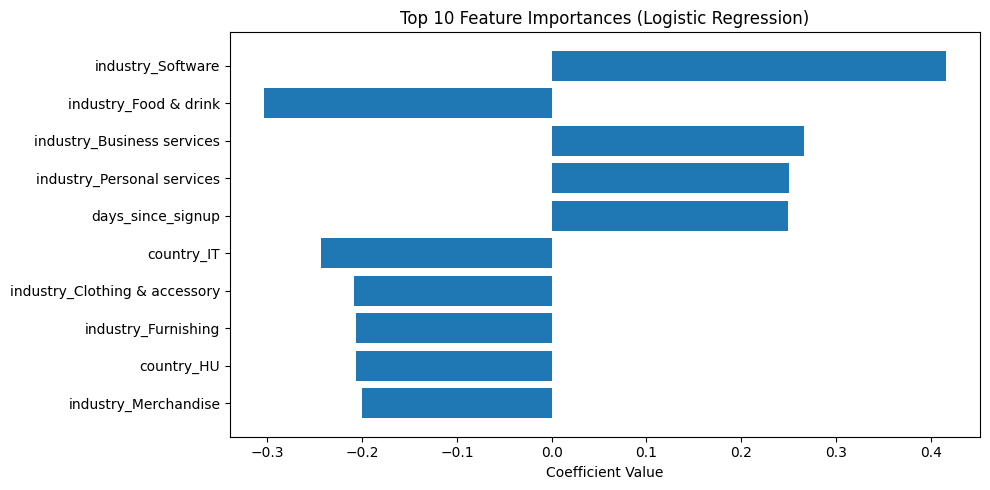

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature names and their coefficients
feature_names = X.columns
coefs = model.coef_[0]

# Sort by absolute importance
sorted_idx = np.argsort(np.abs(coefs))[::-1][:10]

plt.figure(figsize=(10, 5))
plt.barh(range(len(sorted_idx)), coefs[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel("Coefficient Value")
plt.title("Top 10 Feature Importances (Logistic Regression)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()


## Summary

In this project, we analyzed Stripe's merchant and transaction data to identify high-potential users for the Subscriptions product. Specifically, we targeted merchants who have not yet adopted Subscriptions but exhibit strong engagement with other Stripe offerings such as Checkout and Payment Links. By engineering an engagement score, filtering for merchants active for at least 90 days, and ranking them accordingly, we surfaced a list of top candidates suitable for targeted marketing and outreach initiatives.

## Conclusion

Our final recommendations highlight a segment of highly engaged, well-established Stripe merchants who are primed for Subscriptions adoption. These insights offer practical value to Stripe’s product, sales, and marketing teams by enabling focused efforts to drive adoption and increase recurring revenue. With additional data and refinement, this targeting framework can scale to support broader go-to-market strategies.
